In [1]:
import sys
sys.path.append("../src")
import utils
import pandas as pd
import numpy as np
import ot
from tqdm import tqdm
import matplotlib.pyplot as plt
import networkx as nx 
from sklearn.cluster import SpectralClustering

In [2]:
df = pd.read_csv("../data/Langevin_1D.txt", names=['x'])
df.head()

,x
0,0.000000
1,-0.071663
2,-0.042737
3,-0.060637
4,-0.136164


In [3]:
def compute_wass_dists(data, windowsize):
    N = len(data)
    distances = np.zeros((N))
    for t in tqdm(range(windowsize, N - windowsize)):
        mu = df[t - windowsize:t].to_numpy()
        nu = df[t: t+windowsize].to_numpy()
        distances[t] = ot.emd2_1d(mu, nu)
    return distances

In [4]:
df['dists'] = compute_wass_dists(df,300)

100% 99400/99400 [00:27<00:00, 3567.92it/s]


In [5]:
def filter_change_points(
    differences: np.ndarray,
    change_points: np.ndarray,
) -> np.ndarray:
    # find the boundaries of the regions containing consecutive CP candidates
    boundary_pts = []
    for i in range(len(change_points) - 1):
        if change_points[i + 1] - change_points[i] > 1:
            boundary_pts.append(change_points[i])
            boundary_pts.append(change_points[i + 1])  
    boundary_pts.append(len(differences))

    # filter for and output the final change points
    filtered_points = []
    for i in range(len(boundary_pts) - 1):
        lo = boundary_pts[i]
        hi = boundary_pts[i + 1]
        #if hi - lo > 1:
        subset = differences[lo:hi]
        if type(subset) is not np.ndarray:
            subset = np.array(subset)
        filtered_points.append(subset.argmax() + lo)
    return np.array(boundary_pts)

In [6]:
distances = df['dists']
candidates = utils.identify_change_points(distances)
change_points = filter_change_points(distances,candidates) 
print(change_points)

[   520    927   1151   1278   1393   2425   2999   8109   8495  10381
  10570  10744  10932  11095  11514  11823  12215  15926  16152  16616
  16814  18128  18138  18355  18672  20215  20304  21268  21437  21870
  22212  24036  24431  25207  25590  26783  27002  27469  27790  27996
  28115  28396  28716  29415  29694  32012  32434  33778  34183  35700
  35861  36065  36333  39496  39543  39805  39948  41114  41226  41456
  41509  42883  43287  50531  50923  51387  51626  53649  53836  53843
  53858  54061  54306  57666  58051  58369  58769  59310  59740  62487
  62805  63340  63599  63778  64088  71074  71437  71801  72204  73452
  73526  73803  73893  80204  80405  84883  85359  85615  85954  87693
  88013  89300  89337  89595  89678  89955  90404  91253  91524  91754
  91902  96757 100000]


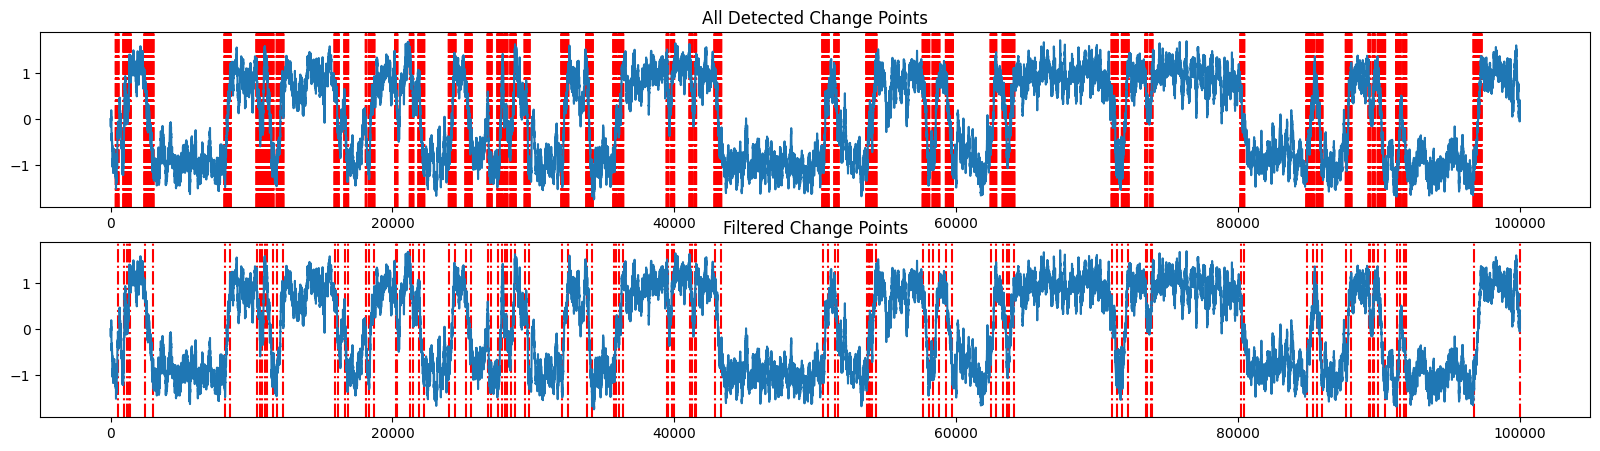

In [7]:
fig, (ax0, ax1) = plt.subplots(2,1)
fig.set_size_inches(20,5)
ax0.plot(df['x'])
ax1.plot(df['x'])
cutoff = np.quantile(df['dists'], 0.85)
for t in candidates:
    ax0.axvline(t, linestyle='dashdot', c='r', zorder=0)
for t in change_points:
    ax1.axvline(t, linestyle='dashdot', c='r', zorder=0)
ax0.set_title("All Detected Change Points")
ax1.set_title('Filtered Change Points')
plt.savefig('Langevin_change_points.pdf', bbox_inches='tight')

In [8]:
def enumerate_states(data, column, cps):
    distributions = []
    num_states = len(cps)
    for i in range(num_states - 1):
        t0, t1 = cps[i], cps[i+1]
        mu = data[column][t0:t1].to_numpy()
        distributions.append(mu)
    return distributions

In [9]:
states = enumerate_states(df, 'x', change_points)

In [10]:
def resample(mu, n):
    observations = len(mu)
    new_mu = np.zeros((n))
    for i in range(n):
        m = np.random.randint(0, observations)
        new_mu[i] = mu[m]
    return new_mu

def compute_pairwise_dists(state_list):
    N = len(state_list)
    dist_mat = np.zeros((N,N))
    for i in tqdm(range(N)):
        mu = state_list[i]
        for j in range(i, N):
            nu = state_list[j]
            dist = ot.emd2_1d(mu, nu)
            dist_mat[i,j], dist_mat[j, i] = dist, dist
    return dist_mat

def resample_and_compute_pairwise_dists(state_list):
    N = len(state_list)
    dist_mat = np.zeros((N,N))
    for i in tqdm(range(N)):
        mu = state_list[i]
        for j in range(N):
            nu = state_list[j]
            sample_size = min(len(mu), len(nu))
            alpha, beta = resample(mu, sample_size), resample(nu, sample_size)
            dist_mat[i,j] = ot.emd2_1d(alpha, beta)
    return dist_mat

In [11]:
wasserstein_distance_matrix = compute_pairwise_dists(states)

100% 112/112 [00:01<00:00, 64.61it/s]


In [12]:
state_lengths = [len(state) for state in states]
np.quantile(state_lengths, .25),np.quantile(state_lengths, .50),np.quantile(state_lengths, .75), np.quantile(state_lengths, .90),

(205.5, 340.5, 794.25, 2288.500000000002)

In [13]:
def knn_similarity_matrix(pw_dists, k=3):
    N, _ = pw_dists.shape
    similarity_matrix = np.zeros((N,N))
    for i in range(N):
        idists = pw_dists[i, :]
        iindices = np.argpartition(idists, -k)[-k:]
        for j in iindices:
            jdists = pw_dists[j, :]
            jindices = np.argpartition(jdists, -k)[-k:]
            if i in jindices:
                similarity_matrix[i, j] = 1
    return similarity_matrix

def filter_distributions(clustered_states, q=0.5):
    cluster_sizes = [len(state) for state in clustered_states]
    cutoff = np.quantile(cluster_sizes, q)
    distributions = []
    for state in clustered_states:
        if len(state) > cutoff:
            distributions.append(state)
    return distributions

def form_sample_matrix(cluster):
    lengths = [len(c) for c in cluster]
    M, N = len(cluster), min(lengths)
    samples = np.zeros((N,M))
    for i in range(M):
        samples[:, i] = resample(cluster[i], N)
    return samples

def gaussian_kernel_similarity_graph(distances, sigma=1):
    return np.exp(-(distances ** 2) / sigma)

def resample_and_compute_bar(sample_matrix, reg=0.1):
    sample_count, ref_count = sample_matrix.shape
    references = [np.array([sample_matrix[:,i]]).T for i in range(ref_count)]
    print(references[0].shape)
    weights = ot.unif(ref_count)
    sample_weights = ot.unif(sample_count)
    measure_weights = [sample_weights for _ in range(ref_count)]
    bar_init = np.random.randn(sample_count, 1)
    bar = ot.bregman.free_support_sinkhorn_barycenter(
        measures_locations = references,
        measures_weights = measure_weights,
        weights = weights,
        X_init = bar_init,
        reg = reg,
    )
    return bar

def compute_bar(states, reg=0.1):
    ref_count = len(states)
    weights = ot.unif(ref_count)
    references = [np.array([states[i]]).T for i in range(len(states))]
    measure_weights = [ot.unif(len(state)) for state in states]
    bar_init = np.random.randn(100, 1)
    bar = ot.bregman.free_support_sinkhorn_barycenter(
        measures_locations = references,
        measures_weights = measure_weights,
        weights = weights,
        X_init = bar_init,
        reg = reg,
    )
    return bar

/usr/local/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


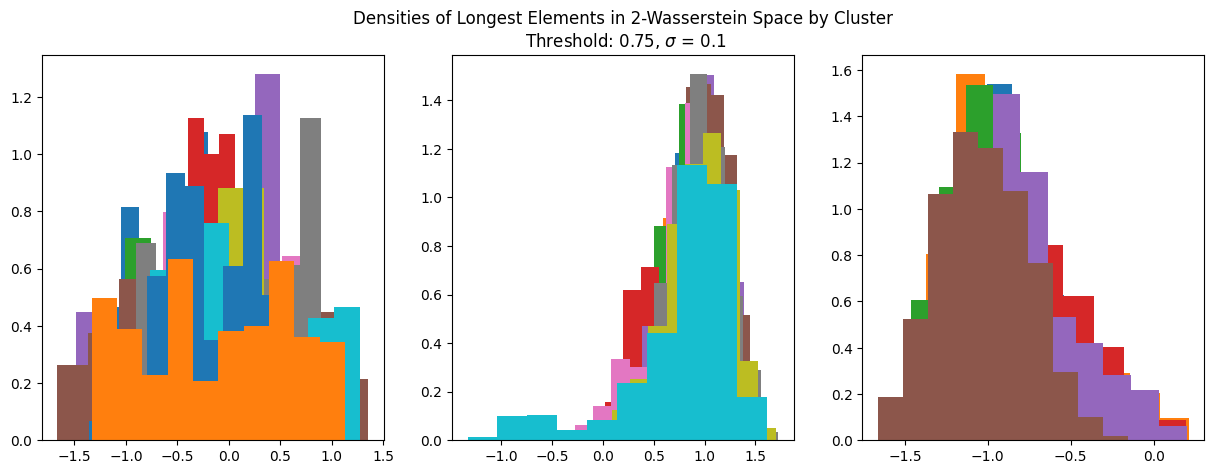

In [14]:
A = wasserstein_distance_matrix
np.average(A), np.max(A)
sigma=0.1
B = gaussian_kernel_similarity_graph(wasserstein_distance_matrix, sigma=sigma)
C = 3
cutoff = 0.75
sc = SpectralClustering(C, affinity="precomputed")
sc.fit_predict(B)
labels = sc.labels_
unique_elements, counts = np.unique(labels, return_counts=True)
duplicate_elements = unique_elements[counts > 1]
indices = [np.where(labels == element)[0] for element in duplicate_elements]
clusters = [[states[i] for i in index_list] for index_list in indices]
cluster_sizes = [len(state) for state in clusters[0]]
filtered = [filter_distributions(cluster, cutoff) for cluster in clusters]
C = len(clusters)
fig, axes = plt.subplots(1,C)
fig.set_size_inches(15,5)
for i in range(C):
    for state in filtered[i]:
        axes[i].hist(state, density=True)
axes[int(C / 2)].set_title(f"Densities of Longest Elements in 2-Wasserstein Space by Cluster\n Threshold: {cutoff}, " + r"$\sigma$ = " + f"{sigma}")
plt.savefig(f"clustered-densities-{cutoff}.pdf", bbox_inches='tight')

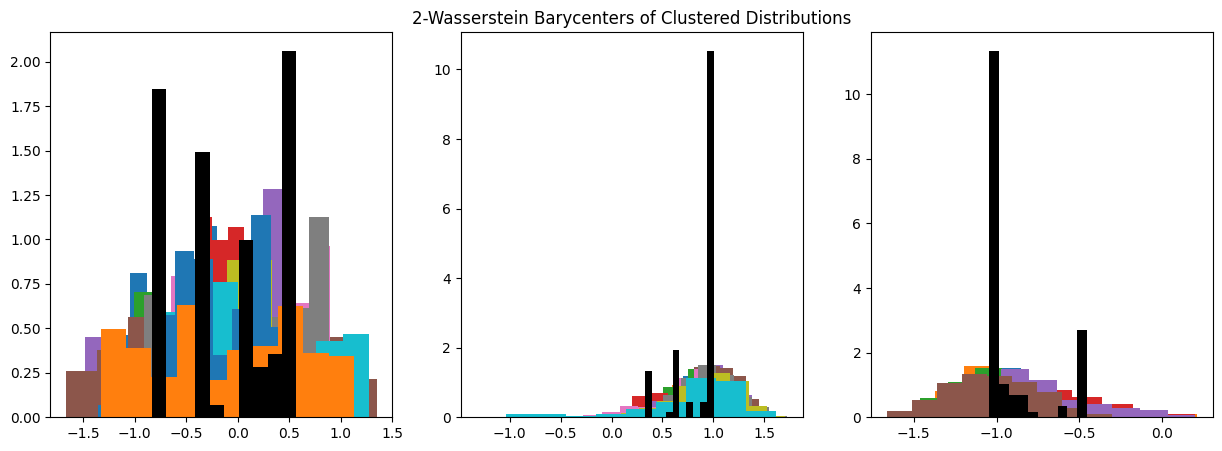

In [15]:
fig, axes = plt.subplots(1,C)
fig.set_size_inches(15,5)
for i in range(C):
    refs = filtered[i]
    axes[i].hist(compute_bar(refs), color='black',zorder=50, density=True)
    for state in filtered[i]:
        axes[i].hist(state, density=True)
axes[int(C / 2)].set_title("2-Wasserstein Barycenters of Clustered Distributions")
plt.savefig("cluster-bars.pdf", bbox_inches='tight')

In [16]:
# use the barycenter to define the boundaries of states
# get the list of states by comparing the trajectory against the boundaries established in the prior step
# use the sequence of states to form a Markov chain
# output its steady state

In [17]:
bar0 = compute_bar(filtered[0])
bar1 = compute_bar(filtered[1])
bar2 = compute_bar(filtered[2])


state_0_lo, state_0_center, state_0_hi = np.quantile(bar0, 0.25), np.quantile(bar0, 0.5), np.quantile(bar0, 0.75)
state_1_lo, state_1_center, state_1_hi = np.quantile(bar1, 0.25), np.quantile(bar1, 0.5), np.quantile(bar1, 0.75)
state_2_lo, state_2_center, state_2_hi = np.quantile(bar2, 0.25), np.quantile(bar2, 0.5), np.quantile(bar2, 0.75)

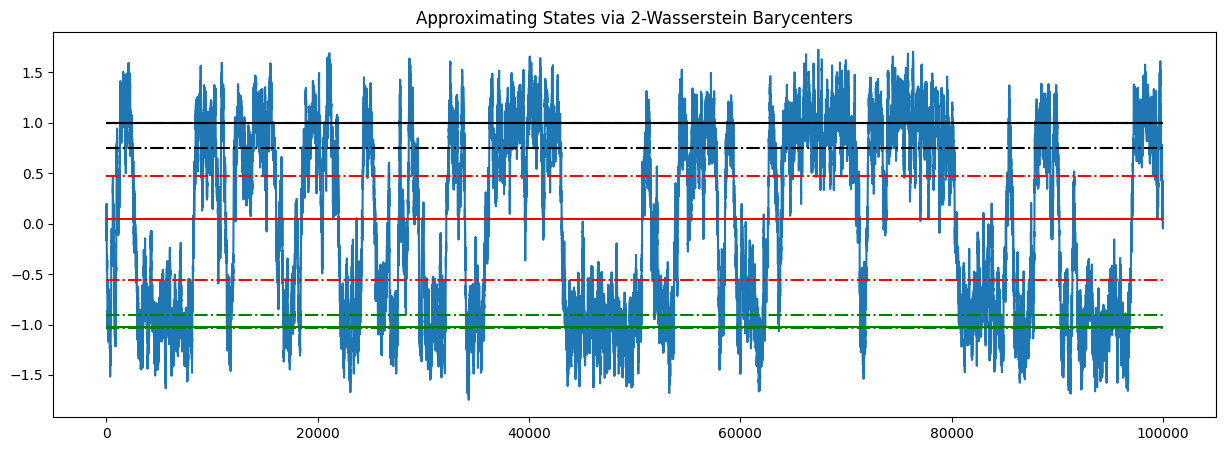

In [18]:
fig, ax = plt.subplots()
fig.set_size_inches(15,5)
ax.plot(df['x'])
ax.hlines(state_0_lo, 0, 10e4, color='red', linestyle='dashdot')
ax.hlines(state_0_hi, 0, 10e4, color='red', linestyle='dashdot')
ax.hlines(state_0_center, 0, 10e4, color='red')

ax.hlines(state_1_center, 0, 10e4, color='black')
ax.hlines(state_1_lo, 0, 10e4, color='black', linestyle='dashdot')
ax.hlines(state_1_hi, 0, 10e4, color='black', linestyle='dashdot')

ax.hlines(state_2_lo, 0, 10e4, color='green', linestyle='dashdot')
ax.hlines(state_2_hi, 0, 10e4, color='green', linestyle='dashdot')
ax.hlines(state_2_center, 0, 10e4, color='green')
plt.title("Approximating States via 2-Wasserstein Barycenters")
plt.savefig("states-with-trajectory.pdf", bbox_inches='tight')

In [19]:
sc.labels_

array([0, 0, 0, 1, 1, 0, 2, 0, 1, 1, 0, 0, 1, 0, 2, 0, 1, 0, 0, 2, 2, 0,
       2, 0, 1, 1, 1, 1, 1, 0, 2, 0, 1, 0, 2, 2, 2, 0, 1, 0, 0, 0, 1, 0,
       2, 0, 1, 0, 2, 2, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 2, 0, 1, 0,
       2, 2, 0, 0, 0, 1, 1, 0, 2, 0, 1, 0, 2, 0, 1, 0, 2, 0, 1, 0, 2, 0,
       1, 1, 0, 1, 1, 0, 2, 0, 1, 0, 2, 0, 1, 1, 0, 1, 1, 0, 2, 2, 0, 2,
       2, 1], dtype=int32)

In [20]:
def markov_chain_from_labels(labels):
    num_obs = len(labels)
    states = np.unique(labels)
    num_states = len(states)
    chain = np.zeros((num_states, num_states))
    for t in range(num_obs - 1):
        chain[labels[t], labels[t + 1]] += 1
    for i in range(num_states):
        row  = chain[i, :]
        chain[i, :] = row / np.linalg.norm(row, 1)
    return chain
    
def find_markov_steady_state(p):
    dim = p.shape[0]
    q = p - np.eye(dim)
    ones = np.ones(dim)
    q = np.c_[q, ones]
    QTQ = np.dot(q, q.T)
    bQT = np.ones(dim)
    return np.linalg.solve(QTQ, bQT)

In [21]:
chain = markov_chain_from_labels(sc.labels_)
print(chain)
print(find_markov_steady_state(chain))

[[0.18367347 0.44897959 0.36734694]
 [0.59459459 0.40540541 0.        ]
 [0.68       0.04       0.28      ]]
[0.43485276 0.34328358 0.22186365]


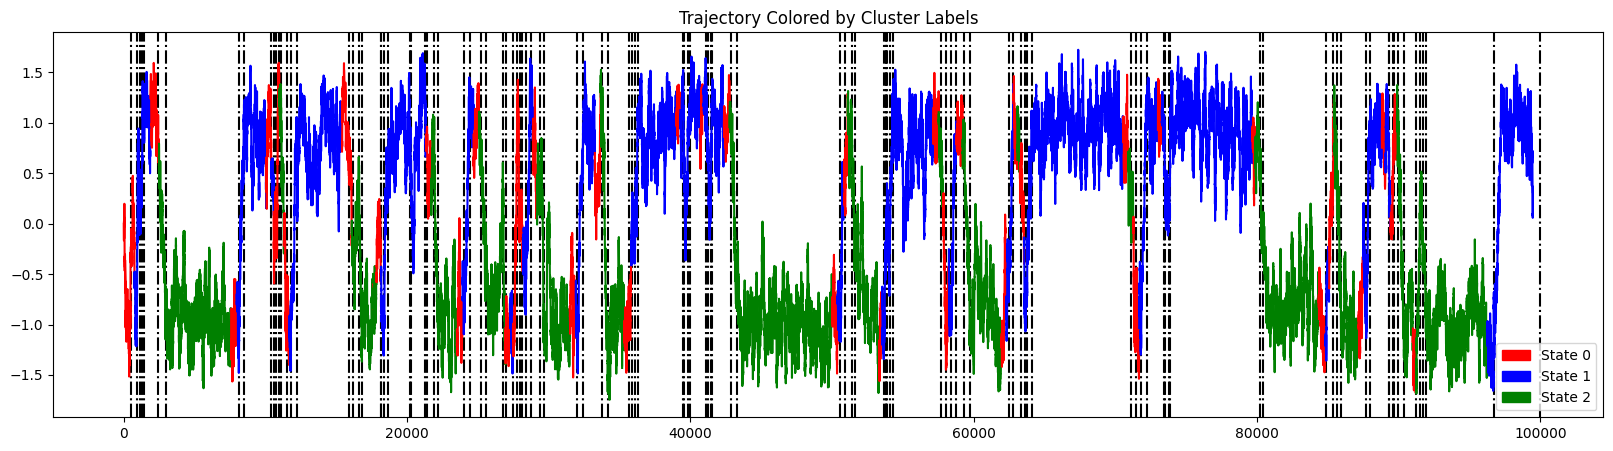

In [25]:
import matplotlib.patches as mpatches
fig, ax = plt.subplots()
fig.set_size_inches(20,5)
t = 0
series = df['x']
labels = sc.labels_
#ax.plot(df['x'],c='purple')
for state, label in zip(states, labels):
    if label == 0:
        c = 'r'
    elif label == 1:
        c = 'b'
    else:
        c = 'g'
    l = len(state)
    t_dom = np.arange(t, t+l)
    ax.plot(t_dom, series[t:t+l], c=c)
    t += l
for t in change_points:
    ax.axvline(t, linestyle='dashdot', c='black', zorder=0)
red_patch = mpatches.Patch(color='red', label='State 0')
blue_patch = mpatches.Patch(color='blue', label='State 1')
green_patch = mpatches.Patch(color='green', label='State 2')
ax.legend(handles=[red_patch, blue_patch, green_patch], loc='best')
ax.set_title("Trajectory Colored by Cluster Labels")
plt.savefig("colored-trajs.pdf", bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots()
series = df['x']
fig.set_size_inches(20,5)
bln = True
t = 0
ax.plot(series, c='purple',zorder=0)
for state in states:
    c = 'blue' if bln else 'red'
    l = len(state)
    t_dom = np.arange(t, t+l)
    
    ax.scatter(t_dom, series[t:t+l],c=c,s=1)
    t += l
    bln = not bln
for t in change_points:
    ax.axvline(t, linestyle='dashdot', c='black', zorder=0)

In [ ]:
fig, (ax0, ax1) = plt.subplots(2,1)
fig.set_size_inches(14,4)
ax0.plot(df['x'])
ax1.plot(df['x'])
t = 0
bln = True
cutoff = np.quantile(df['dists'], 0.85)
for state in states:
    c = 'blue' if bln else 'red'
    l = len(state)
    t_dom = np.arange(t, t+l)
    ax0.plot(t_dom, series[t:t+l],c=c)
    t += l
    bln = not bln
for t in change_points:
    ax1.axvline(t, linestyle='dashdot', c='r', zorder=0)

In [ ]:
np.max(bar0), np.min(bar0),np.max(bar1), np.min(bar1),np.max(bar2), np.min(bar2),